### RecSys Challenge 2015
#### http://2015.recsyschallenge.com/
#### In which we pedict the buying patterns

### Learn from others
1. twitter @ACMRecSys
2. iPython notebook by @jbochi http://nbviewer.ipython.org/github/jbochi/recsyschallenge2015/blob/master/visualization.ipynb
3. blogs by @totopampin http://aloneindecember.com/words/recsys-challenge-part-iii/


In [1]:
import datetime
from pytz import timezone
print("Last run @%s" % (datetime.datetime.now(timezone('US/Pacific'))))

Last run @2022-01-24 18:01:45.442228-08:00


In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print('pandas: ',pd.__version__)
import ggplot

pandas:  1.3.4


In [4]:
buys = pd.read_csv("data/recsys-2015/yoochoose-buys.dat", 
                   names=["session", "timestamp", "item", "price", "qty"], 
                   parse_dates=["timestamp"])

In [5]:
def read_clicks(filename):
    return pd.read_csv(filename, 
                     names=["session", "timestamp", "item", "category"], 
                     parse_dates=["timestamp"],
                     converters={"category": lambda c: -1 if c == "S" else c})

In [6]:
%%time
clicks = read_clicks("data/recsys-2015/yoochoose-clicks.dat")
test = read_clicks("data/recsys-2015/yoochoose-test.dat")

CPU times: user 2min 24s, sys: 9.85 s, total: 2min 34s
Wall time: 2min 37s


In [114]:
%lsmagic
# cell magic starts with %% and line magic starts with %

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3

In [115]:
clicks.count()

session      33003944
timestamp    33003944
item         33003944
category     33003944
dtype: int64

In [116]:
clicks.head()

session               timestamp       item category
0        1 2014-04-07 10:51:09.277  214536502        0
1        1 2014-04-07 10:54:09.868  214536500        0
2        1 2014-04-07 10:54:46.998  214536506        0
3        1 2014-04-07 10:57:00.306  214577561        0
4        2 2014-04-07 13:56:37.614  214662742        0

#### 1. Session ID = ID of the session. In one session there are one or many clicks. Could be represented as an integer number.
#### 2. Timestamp = Time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
#### 3. Item ID = Unique identifier of the item that has been clicked. Could be represented as an integer number.
#### 4. Category = Context of the click.
#####      - "S" indicates a special offer,
#####      - "0" indicates  a missing value,
#####      - A number between 1 to 12 indicates a real category identifier
#####      - Any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12. 


In [117]:
buys.count()

session      1150753
timestamp    1150753
item         1150753
price        1150753
qty          1150753
dtype: int64

In [118]:
buys.head()

session               timestamp       item  price  qty
0   420374 2014-04-06 18:44:58.314  214537888  12462    1
1   420374 2014-04-06 18:44:58.325  214537850  10471    1
2   281626 2014-04-06 09:40:13.032  214535653   1883    1
3   420368 2014-04-04 06:13:28.848  214530572   6073    1
4   420368 2014-04-04 06:13:28.858  214835025   2617    1

#### 1. Session ID - Id of the session. In one session there are one or many buying events. Could be represented as an integer number.
#### 2. Timestamp - Time when the buy occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
#### 3. Item ID - the unique identifier of item that has been bought. Could be represented as an integer number.
#### 4. Price - the price of the item. Could be represented as an integer number.
#### 5. Quantity - the quantity in this buying.  Could be represented as an integer number.```

In [119]:
test.count()

session      8251791
timestamp    8251791
item         8251791
category     8251791
dtype: int64

##### Test same as Click ie Session ID,Time Stamp,Item Id, Click Context

## Challenge as part of the RecSys Conference
#### The task is to predict for each session in the test file, whether there is going to be a buying event in this session, and if there is, what are the items that will be bought. _No need to predict quantities._
#### The solution file, that has to be submitted, comprises records that have exactly two fields:
#### solution.dat
#### 1. Session ID
#### 2. Comma separated list of Item IDs that have been bought in this session



2263615;214748295
 
2541095;214748291,214748300,214831965,214831948


In [120]:
# Plan & Ideas - Stare at data/read Blogs/Think/Extrapolate experience
#
# Assumptions
#   Assume Session ID are independnt ie not a user id
#   Session ID is relevant, but needs feature engineering
#   Are Items independent of each other (ie i.i.d)
#     Is there a relationship between clicks of multiple items and a buy ?
# To Try
#   Do all sessions in buy have respective clicks ? <Yes>
#   Clicked - Bought ratio by Category, by Item
#   Category - Bought ratio by Category, by Item
#   Items not in Clicked but in Test ? What would we do ? category base default ? Time based default ? Or ensamble ?
#   Time - Ignored here
#     Time dimension (HW) - which category, item has the best chance of buying based on time of click
#     Time Period in Daypart ? Hour granularity ? 30 min granularity ?
#     Browse time of an item vs Buy
#     Browse only items - never bought
#     Browse Time vs buy conversion ratio
#     Number of times browser vs buy
#     Session length
#     Session Clicks
#     Buy efficiency
#     Run STL - weekly trends - What is the seasonality ? Hour of week ?
#     Run ARIMA
#     Aggregate Day of the week - Buys vs Clicks, Histogram 
#     Aggregate by DayPart of week 24 X 7 = 168 - Buy vs. Click
#
#     Would naive Bayes work ?
#   This is a Classicication Problem. But what are the features ?
# Inferences
# 
# 53 % Buys have no qty !
#
#


### Step 1 - Sanity Check : an overview of the dataset, look for anomalys and incongruencies
Ref: iPython notebook by @jbochi

#### 1.1 Verify Date Range

In [121]:
print("Clicks : ",clicks["timestamp"].min(), clicks["timestamp"].max())
print("  Test : ",test["timestamp"].min(), test["timestamp"].max())
print("  Buys : ", buys["timestamp"].min(), buys["timestamp"].max())

Clicks :  2014-04-01 03:00:00.124000 2014-09-30 02:59:59.430000
  Test :  2014-04-01 03:00:08.250000 2014-09-30 02:59:23.866000
  Buys :  2014-04-01 03:05:31.743000 2014-09-30 02:35:12.859000


#### 1.2 Stats

In [122]:
clicks.dtypes

session               int64
timestamp    datetime64[ns]
item                  int64
category             object
dtype: object

In [123]:
buys.dtypes

session               int64
timestamp    datetime64[ns]
item                  int64
price                 int64
qty                   int64
dtype: object

In [124]:
%%time
print("Clicks : ",clicks.count())
print("Buys : ", buys.count()) 

Clicks :  session      33003944
timestamp    33003944
item         33003944
category     33003944
dtype: int64
Buys :  session      1150753
timestamp    1150753
item         1150753
price        1150753
qty          1150753
dtype: int64
CPU times: user 3.88 s, sys: 338 ms, total: 4.22 s
Wall time: 4.43 s


In [7]:
%%time
print("Unique Sessions : ","Clicks : ",clicks["session"].unique().size)
print("Buys : ",buys["session"].unique().size)
print("Buy Percentage by session : %.2f%%" %(100.0 * buys["session"].unique().size/clicks["session"].unique().size))
## Notice size not size(), unique() returns a numpy array

Unique Sessions :  Clicks :  9249729 Buys :  509696
Buy Percentage by session : 5.51%
CPU times: user 1.5 s, sys: 474 ms, total: 1.97 s
Wall time: 1.97 s


In [8]:
print("Unique Items : ","Clicks : ",clicks["item"].unique().size)
print("Buys : ",buys["item"].unique().size)

Unique Items :  Clicks :  52739 Buys :  19949


In [9]:
# Item Stats - Items/session
buys[["session","item"]].groupby("session").count().describe()

item
count  509696.000000
mean        2.257724
std         1.933342
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       144.000000

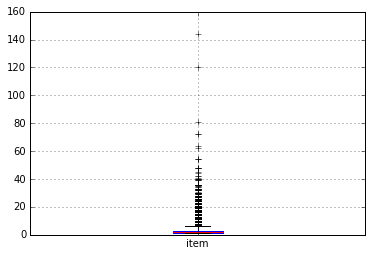

In [10]:
buys[["session","item"]].groupby("session").count().boxplot(return_type='axes')

In [13]:
# Session duration
ts_by_session = clicks[["session", "timestamp"]].groupby("session")
ts_by_session.head(5)

session               timestamp
0                1 2014-04-07 10:51:09.277
1                1 2014-04-07 10:54:09.868
2                1 2014-04-07 10:54:46.998
3                1 2014-04-07 10:57:00.306
4                2 2014-04-07 13:56:37.614
5                2 2014-04-07 13:57:19.373
6                2 2014-04-07 13:58:37.446
7                2 2014-04-07 13:59:50.710
8                2 2014-04-07 14:00:38.247
10               3 2014-04-02 13:17:46.940
11               3 2014-04-02 13:26:02.515
12               3 2014-04-02 13:30:12.318
13               4 2014-04-07 12:09:10.948
14               4 2014-04-07 12:26:25.416
15               6 2014-04-06 16:58:20.848
16               6 2014-04-06 17:02:26.976
17               7 2014-04-02 06:38:53.104
18               7 2014-04-02 06:39:05.854
19               8 2014-04-06 08:49:58.728
20               8 2014-04-06 08:52:12.647
21               9 2014-04-06 11:26:24.127
22               9 2014-04-06 11:28:54.654
23               9 2014-04-06 11:29:13.479
24              11 2014-04-03 10:44:35.672
25              11 2014-04-03 10:45:01.674
26              11 2014-04-03 10:45:29.873
27              11 2014-04-03 10:46:12.162
28              11 2014-04-03 10:46:57.355
36              12 2014-04-02 10:30:13.176
37              12 2014-04-02 10:33:12.621
...            ...                     ...
33003912  11299822 2014-09-28 04:38:10.567
33003913  11299823 2014-09-29 07:06:28.550
33003914  11299816 2014-09-29 20:00:25.331
33003915  11299816 2014-09-29 20:03:17.312
33003916  11299816 2014-09-29 20:06:15.461
33003917  11299816 2014-09-29 20:12:02.435
33003918  11299816 2014-09-29 20:30:34.135
33003920  11299817 2014-09-24 18:33:52.512
33003921  11299818 2014-09-24 19:55:11.248
33003922  11299818 2014-09-24 19:55:12.619
33003923  11299819 2014-09-25 08:29:28.743
33003924  11299819 2014-09-25 08:30:27.345
33003925  11299819 2014-09-25 08:31:39.129
33003926  11299812 2014-09-23 12:57:54.770
33003927  11299812 2014-09-23 13:00:59.846
33003928  11299812 2014-09-23 13:03:20.359
33003929  11299813 2014-09-24 16:21:48.003
33003930  11299813 2014-09-24 16:24:42.314
33003931  11299813 2014-09-24 16:30:40.442
33003932  11299813 2014-09-24 16:34:32.102
33003933  11299813 2014-09-24 16:34:57.172
33003935  11299814 2014-09-29 16:54:36.153
33003936  11299808 2014-09-27 15:23:24.869
33003937  11299809 2014-09-25 09:28:02.827
33003938  11299809 2014-09-25 09:28:54.290
33003939  11299809 2014-09-25 09:33:22.412
33003940  11299809 2014-09-25 09:43:52.821
33003941  11299811 2014-09-24 19:02:09.741
33003942  11299811 2014-09-24 19:02:11.894
33003943  11299811 2014-09-24 19:02:25.146

[26372937 rows x 2 columns]

In [14]:
min_ts = ts_by_session.min() # Because ts_by_session has a hierarchical index, this gives min per group !
max_ts = ts_by_session.max()
duration = max_ts - min_ts
duration.head()

timestamp
session                
1       00:05:51.029000
2       00:05:59.275000
3       00:12:25.378000
4       00:17:14.468000
6       00:04:06.128000

In [15]:
duration.describe()

timestamp
count                 9249729
mean   0 days 00:06:21.633378
std    0 days 00:12:36.645009
min           0 days 00:00:00
25%    0 days 00:00:32.214000
50%    0 days 00:02:07.939000
75%    0 days 00:06:24.132000
max    2 days 20:18:57.996000

### 3. Clicks n' Buys

#### Question : Do all buys have sessions in click ? 
##### Find Buys without clicks and clicks without buys - on (Session,ItemID) from buys & Clicks
##### Anti-join in Pandas ?
##### Test Result to verify correctness: 
#####      - Clicks without buys = 29,698,257 out of 33,003,944. 1,150,753 Buys
#####     - Buys without clicks - none!

In [132]:
%%time
item_buys = buys[["session", "item", "qty"]].groupby(["session", "item"]).sum()

CPU times: user 481 ms, sys: 152 ms, total: 633 ms
Wall time: 655 ms


In [133]:
item_buys.columns = ["Bought"]
item_buys.head()

Bought
session item             
11      214821371       2
12      214717867       4
21      214548744       1
        214838503       1
33      214706441       2

In [134]:
%%time
item_clicks = clicks[["session", "item", "timestamp"]].groupby(["session", "item"]).count()

CPU times: user 16.9 s, sys: 6.28 s, total: 23.1 s
Wall time: 26.3 s


In [135]:
item_clicks.columns = ["Clicked"]
item_clicks.head()

Clicked
session item              
1       214536500        1
        214536502        1
        214536506        1
        214577561        1
2       214551617        1

In [136]:
%%time
e2e_ses = pd.merge(item_clicks, item_buys, how='outer', left_index=True, right_index=True)

CPU times: user 44.9 s, sys: 10.8 s, total: 55.7 s
Wall time: 60 s


In [137]:
e2e_ses.head()

Clicked  Bought
session item                      
1       214536500        1     NaN
        214536502        1     NaN
        214536506        1     NaN
        214577561        1     NaN
2       214551617        1     NaN

In [138]:
e2e_ses.count() # number of non-null items

Clicked    26615576
Bought      1049817
dtype: int64

In [139]:
print("Buy Percentage by Item : %.2f%%" %(100.0 * e2e_ses["Bought"].count() / e2e_ses["Clicked"].count()))

Buy Percentage by Item : 3.94%


In [93]:
print(item_clicks.size)

26615576


In [98]:
e2e_ses[pd.isnull(e2e_ses['Clicked'])]

Empty DataFrame
Columns: [Clicked, Bought]
Index: []

In [100]:
e2e_ses.describe()

/Users/ksankar/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Clicked        Bought
count  2.661558e+07  1.049817e+06
mean   1.240024e+00  7.082053e-01
std    6.613830e-01  1.398469e+00
min    1.000000e+00  0.000000e+00
25%    1.000000e+00           NaN
50%    1.000000e+00           NaN
75%    1.000000e+00           NaN
max    2.000000e+02  1.400000e+02

In [103]:
e2e_ses.fillna(0,inplace=True).describe()

Clicked        Bought
count  2.661558e+07  2.661558e+07
mean   1.240024e+00  2.793424e-02
std    6.613830e-01  3.100701e-01
min    1.000000e+00  0.000000e+00
25%    1.000000e+00  0.000000e+00
50%    1.000000e+00  0.000000e+00
75%    1.000000e+00  0.000000e+00
max    2.000000e+02  1.400000e+02

In [104]:
# More clicks = more buys?
e2e_ses["Clicked"].corr(e2e_ses["Bought"])

0.10215779997428077

### Step 2 - Feature Exraction

#### Add feature ClickDayPart = HourofDay & DayOfWeek
#### DayPart is a feature used widely in AdTech. Let us apply that technique here

In [141]:
buys.head()

session               timestamp       item  price  qty
0   420374 2014-04-06 18:44:58.314  214537888  12462    1
1   420374 2014-04-06 18:44:58.325  214537850  10471    1
2   281626 2014-04-06 09:40:13.032  214535653   1883    1
3   420368 2014-04-04 06:13:28.848  214530572   6073    1
4   420368 2014-04-04 06:13:28.858  214835025   2617    1

In [142]:
clicks.head()

session               timestamp       item category
0        1 2014-04-07 10:51:09.277  214536502        0
1        1 2014-04-07 10:54:09.868  214536500        0
2        1 2014-04-07 10:54:46.998  214536506        0
3        1 2014-04-07 10:57:00.306  214577561        0
4        2 2014-04-07 13:56:37.614  214662742        0

In [155]:
buys["dayOfWeek"] = buys['timestamp'].dt.dayofweek # Notice that there is no function call ie dayofweek()
buys["hourOfDay"] = buys['timestamp'].dt.hour 
buys["weekOfYear"] = buys['timestamp'].dt.weekofyear 
buys.head()

session               timestamp       item  price  qty  dayofweek  \
0   420374 2014-04-06 18:44:58.314  214537888  12462    1          6   
1   420374 2014-04-06 18:44:58.325  214537850  10471    1          6   
2   281626 2014-04-06 09:40:13.032  214535653   1883    1          6   
3   420368 2014-04-04 06:13:28.848  214530572   6073    1          4   
4   420368 2014-04-04 06:13:28.858  214835025   2617    1          4   

   hourofday  weefofyear  dayOfWeek  hourOfDay  weekOfYear  
0         18          14          6         18          14  
1         18          14          6         18          14  
2          9          14          6          9          14  
3          6          14          4          6          14  
4          6          14          4          6          14

In [156]:
clicks["dayOfWeek"] = clicks['timestamp'].dt.dayofweek 
clicks["hourOfDay"] = clicks['timestamp'].dt.hour 
clicks["weekOfYear"] = clicks['timestamp'].dt.weekofyear 
clicks.head()

session               timestamp       item category  dayofweek  hourofday  \
0        1 2014-04-07 10:51:09.277  214536502        0          0         10   
1        1 2014-04-07 10:54:09.868  214536500        0          0         10   
2        1 2014-04-07 10:54:46.998  214536506        0          0         10   
3        1 2014-04-07 10:57:00.306  214577561        0          0         10   
4        2 2014-04-07 13:56:37.614  214662742        0          0         13   

   weefofyear  dayOfWeek  hourOfDay  weekOfYear  
0          15          0         10          15  
1          15          0         10          15  
2          15          0         10          15  
3          15          0         10          15  
4          15          0         13          15

In [163]:
clicks_by_day = clicks['dayOfWeek'].groupby(clicks['dayOfWeek']).count().to_frame("Clicked")
clicks_by_day.head(10)

Clicked
dayOfWeek         
0          6578482
1          2233498
2          4795554
3          4512049
4          3615548
5          3908733
6          7360080

In [164]:
buys_by_day = buys['dayOfWeek'].groupby(buys['dayOfWeek']).count().to_frame("Bought")
buys_by_day.head(10)

Bought
dayOfWeek        
0          215594
1           40925
2          147451
3          146158
4          126955
5          171441
6          302229

In [176]:
e2e_by_day = pd.merge(clicks_by_day, buys_by_day, how='outer', left_index=True, right_index=True)
e2e_by_day.index = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
e2e_by_day

Clicked  Bought
Sunday     6578482  215594
Monday     2233498   40925
Tuesday    4795554  147451
Wednesday  4512049  146158
Thursday   3615548  126955
Friday     3908733  171441
Saturday   7360080  302229

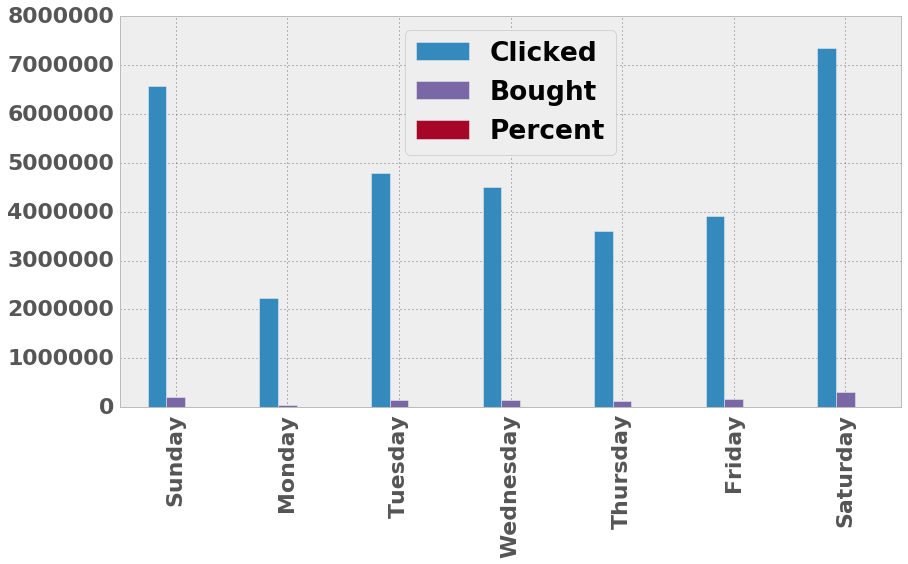

In [179]:
e2e_by_day.plot(kind="bar")

In [178]:
e2e_by_day["Percent"] = 100.0 * e2e_by_day["Bought"] / e2e_by_day["Clicked"]
e2e_by_day

Clicked  Bought   Percent
Sunday     6578482  215594  3.277261
Monday     2233498   40925  1.832328
Tuesday    4795554  147451  3.074744
Wednesday  4512049  146158  3.239282
Thursday   3615548  126955  3.511363
Friday     3908733  171441  4.386102
Saturday   7360080  302229  4.106328

In [ ]:
# There is a difference in buys on different day of the week

### Addendum

#### Interesting Technique combining apply to groupby date

In [174]:
# some display options to make figures bigger
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 400)
pd.set_option('display.mpl_style', 'default')
rcParams['figure.figsize'] = (14, 7)
import matplotlib
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

CPU times: user 1min 48s, sys: 7.87 s, total: 1min 56s
Wall time: 2min


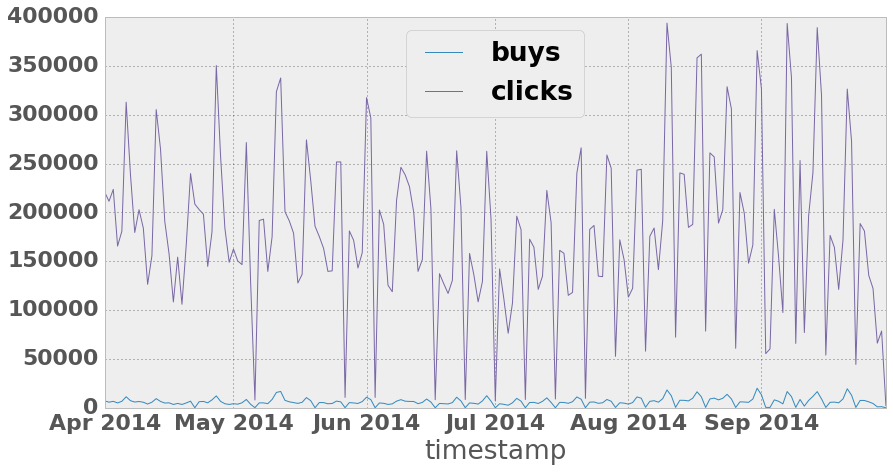

In [175]:
%%time
#Buys and clicks per day
buys_grouped_dates = buys["timestamp"].groupby(buys["timestamp"].apply(lambda x : x.date()))
buys_by_date = buys_grouped_dates.count()
buys_by_date = buys_by_date.to_frame(name="buys")

clicks_grouped_dates = clicks["timestamp"].groupby(clicks["timestamp"].apply(lambda x : x.date()))
clicks_by_date = clicks_grouped_dates.count()
clicks_by_date = clicks_by_date.to_frame(name="clicks")

buys_and_click_by_date = pd.merge(buys_by_date, clicks_by_date, how='outer', left_index=True, right_index=True)
buys_and_click_by_date.fillna(0, inplace=True)

buys_and_click_by_date.plot()

### Step 3 - ML Modelling & Prediction

In [ ]:
#Outside this session ...

### _That's All, Folks !_